# Structured Autoencoder: 2D Content + 6D Transform

**Minimal Training Notebook - Updated for Corrected Architecture**

- **2D Content Latent**: Digit identity/shape clustering ✅ IMPROVED!
- **6D Transform Latent**: Spatial transformations  
- **Cloud Ready**: CUDA/CPU optimization
- **Simplified Loss**: Uses new affine+KL loss function
- **Explicit Imports**: Clear module references (structured_2d6d_autoencoder, affine_autoencoder_shared)

## 🎯 **CORRECTED ARCHITECTURE (v2):**
1. **Input → Encoder → 2D Content Latent**
2. **2D Content Latent → Decoder → Clean Canonical Digit** ⭐ KEY CHANGE
3. **Input → Transform Encoder → 6D Affine Parameters**
4. **Apply Affine Transform to Clean Digit → Final Output**
5. **Loss: Compare Final Output to Original Input**

### Expected Improvements:
- **Much better digit clustering** in 2D latent space
- **Clean canonical digits** from decoder (before transformation)
- **More interpretable latent representations**

## 🔄 Architecture Evolution

### ❌ **V1 (Original - Incorrect):**
- Decoder input: `content_latent + transform_latent` (8D)
- Transform parameters fed INTO decoder
- Result: Poor digit separation, confusing latent space

### ⚠️ **V2 (Fixed but Unstable):**
- Decoder input: `content_latent` only (2D)
- Transform latent deterministic (no KL loss)
- Result: Training collapse at epoch 14!

### ✅ **V3 (UNIFIED 8D VAE - Current):**
- **Single encoder** → **8D latent space** (μ and σ for ALL dimensions)
- **All 8 parameters under KL loss** - balanced training!
- **First 2D** → Decoder → Clean digits
- **Last 6D** → Affine transform parameters (constrained to prevent rotations)
- **Properly normalized losses** for stable beta tuning
- **Result: Stable training, no collapse!**

## 🎛️ **Beta Parameter Tuning Guide:**
- **β < 0.005**: Too weak KL regularization → latent collapse
- **β = 0.005-0.010**: Sweet spot for 8D latent
- **β > 0.015**: Too strong → training collapse

**Current β = 0.008** should provide stable training with good digit clustering!

In [4]:
import torch
# Explicit imports from modular structure
import structured_2d6d_autoencoder as s2d6d
import affine_autoencoder_shared as shared

# 🚀 CONFIG - Updated for UNIFIED 8D VAE with PROPERLY NORMALIZED losses
CONFIG = {
    'content_latent_dim': 2, 'transform_latent_dim': 6, 'total_latent_dim': 8,
    'epochs': 40, 'learning_rate': 1e-3, 'batch_size_train': 256, 'batch_size_test': 128,
    'alpha': 1.0,  # Reconstruction loss weight
        'beta': 0.01,  # KL divergence weight - TUNED for 8D latent (sweet spot: 0.005-0.01)
    'force_cuda': True, 'mixed_precision': True, 'gradient_clip': 1.0,
    'pin_memory': True, 'num_workers': 4, 'weight_decay': 1e-5,
    'lr_scheduler': True, 'early_stopping': True, 'patience': 15,
    'data_dir': '../data', 'save_dir': './', 'checkpoint_freq': 10
}

print("🎯 UNIFIED 8D VAE CONFIGURATION (FIXED):")
print(f"  - ALL {CONFIG['total_latent_dim']} dimensions under KL regularization")
print(f"  - Beta = {CONFIG['beta']} (tuned for stability)")
print(f"  - Loss functions properly normalized")
print(f"  - Affine transforms constrained to prevent 90° rotations")
print(f"  - Should be much more stable training!")

🎯 UNIFIED 8D VAE CONFIGURATION (FIXED):
  - ALL 8 dimensions under KL regularization
  - Beta = 0.01 (tuned for stability)
  - Loss functions properly normalized
  - Affine transforms constrained to prevent 90° rotations
  - Should be much more stable training!


In [5]:
# 🌩️ SETUP - Using shared utilities with explicit module reference
device = shared.get_cloud_device(CONFIG)
scaler = torch.cuda.amp.GradScaler() if CONFIG['mixed_precision'] and device.type == 'cuda' else None
train_loader, test_loader = shared.get_cloud_mnist_loaders(**{k: v for k, v in CONFIG.items() if k in ['batch_size_train', 'batch_size_test', 'data_dir', 'pin_memory', 'num_workers']})

🚀 Cloud CUDA device: GRID A100X-8C
💾 GPU Memory: 8.6GB
📊 Train batches: 235, Test batches: 79


/tmp/ipykernel_25509/1759643369.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if CONFIG['mixed_precision'] and device.type == 'cuda' else None


In [6]:
# 🏗️ MODEL - Using structured_2d6d_autoencoder module explicitly
model = s2d6d.StructuredAffineInvariantAutoEncoder(
    content_dim=CONFIG['content_latent_dim'],
    transform_dim=CONFIG['transform_latent_dim']
).to(device)

In [ ]:
# 📂 OPTIONAL: LOAD EXISTING MODEL (comment out to train new)
# shared.list_saved_models()  # List available models (from affine_autoencoder_shared)
# model, CONFIG, device = shared.load_model_cloud("structured_model_YYYYMMDD_HHMMSS.pth")
# Note: Use shared.* functions from affine_autoencoder_shared module
# 
# 🚨 IMPORTANT: This model uses the CORRECTED architecture where:
# - Decoder takes ONLY content latent (2D), not content+transform (8D)
# - Affine transformation is applied AFTER decoder output
# - Model returns: (input_x, content_latent, transform_latent, unused, clean_reconstruction, content_mu, content_logvar, final_reconstruction)

In [7]:
# 🚀 TRAIN - UNIFIED 8D VAE Architecture
# ✅ This training function now works with the UNIFIED architecture where ALL 8D are under KL loss
print("🎯 Training with UNIFIED 8D VAE ARCHITECTURE:")
print("  - Single encoder → 8D latent (μ, σ for all dimensions)")
print("  - ALL 8 parameters under KL regularization")
print("  - First 2D → Decoder → Clean canonical digits")
print("  - Last 6D → Affine transformation parameters (CONSTRAINED)")
print("  - Loss properly normalized: MSE per-pixel + KL per-dimension")
print("  - Affine transforms constrained to prevent unwanted rotations")
print("  - Should prevent training collapse with balanced regularization!")
print()

losses_dict = s2d6d.train_structured_autoencoder_simplified(model, train_loader, test_loader, device, CONFIG, scaler)

🎯 Training with UNIFIED 8D VAE ARCHITECTURE:
  - Single encoder → 8D latent (μ, σ for all dimensions)
  - ALL 8 parameters under KL regularization
  - First 2D → Decoder → Clean canonical digits
  - Last 6D → Affine transformation parameters (CONSTRAINED)
  - Loss properly normalized: MSE per-pixel + KL per-dimension
  - Affine transforms constrained to prevent unwanted rotations
  - Should prevent training collapse with balanced regularization!



Epoch 1:   0%|          | 0/235 [00:00<?, ?it/s]/home/exouser/Documents/adversAE/adversae/vae_training/affine/structured_2d6d_autoencoder.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast() if scaler else torch.enable_grad():
Epoch 1: 100%|██████████| 235/235 [00:04<00:00, 52.94it/s]


Epoch 1: Train=0.804277, Test=0.754687, Recon=0.755017, KL=4.925936


Epoch 2: 100%|██████████| 235/235 [00:03<00:00, 59.97it/s]


Epoch 2: Train=0.737486, Test=0.733213, Recon=0.655226, KL=8.225996


Epoch 3: 100%|██████████| 235/235 [00:03<00:00, 59.06it/s]


Epoch 3: Train=0.725604, Test=0.728013, Recon=0.636852, KL=8.875184


Epoch 4: 100%|██████████| 235/235 [00:03<00:00, 61.30it/s]


Epoch 4: Train=0.720866, Test=0.723765, Recon=0.629285, KL=9.158066


Epoch 5: 100%|██████████| 235/235 [00:03<00:00, 70.42it/s]


Epoch 5: Train=0.717367, Test=0.720534, Recon=0.624147, KL=9.321929


Epoch 6: 100%|██████████| 235/235 [00:03<00:00, 71.69it/s]


Epoch 6: Train=0.715781, Test=0.719179, Recon=0.621651, KL=9.413029


Epoch 7: 100%|██████████| 235/235 [00:03<00:00, 72.43it/s]


Epoch 7: Train=0.714560, Test=0.717812, Recon=0.619425, KL=9.513536


Epoch 8: 100%|██████████| 235/235 [00:03<00:00, 72.11it/s]


Epoch 8: Train=0.713601, Test=0.717751, Recon=0.618068, KL=9.553280


Epoch 9: 100%|██████████| 235/235 [00:03<00:00, 72.05it/s]


Epoch 9: Train=0.712442, Test=0.718118, Recon=0.616499, KL=9.594315


Epoch 10: 100%|██████████| 235/235 [00:03<00:00, 70.07it/s]


Epoch 10: Train=0.711668, Test=0.717564, Recon=0.615456, KL=9.621276


Epoch 11: 100%|██████████| 235/235 [00:03<00:00, 69.30it/s]


Epoch 11: Train=0.710592, Test=0.715388, Recon=0.614180, KL=9.641235


Epoch 12: 100%|██████████| 235/235 [00:03<00:00, 64.51it/s]


Epoch 12: Train=0.710787, Test=0.715146, Recon=0.613697, KL=9.709067


Epoch 13: 100%|██████████| 235/235 [00:03<00:00, 68.57it/s]


Epoch 13: Train=0.709958, Test=0.714573, Recon=0.612860, KL=9.709809


Epoch 14: 100%|██████████| 235/235 [00:03<00:00, 67.87it/s]


Epoch 14: Train=0.709587, Test=0.713157, Recon=0.612141, KL=9.744658


Epoch 15: 100%|██████████| 235/235 [00:03<00:00, 70.41it/s]


Epoch 15: Train=0.709361, Test=0.714506, Recon=0.611954, KL=9.740731


Epoch 16: 100%|██████████| 235/235 [00:03<00:00, 70.21it/s]


Epoch 16: Train=0.709147, Test=0.715037, Recon=0.611346, KL=9.780162


Epoch 17: 100%|██████████| 235/235 [00:03<00:00, 70.55it/s]


Epoch 17: Train=0.708826, Test=0.713905, Recon=0.610973, KL=9.785363


Epoch 18: 100%|██████████| 235/235 [00:03<00:00, 70.17it/s]


Epoch 18: Train=0.708257, Test=0.714166, Recon=0.610279, KL=9.797779


Epoch 19: 100%|██████████| 235/235 [00:03<00:00, 72.25it/s]


Epoch 19: Train=0.708036, Test=0.713916, Recon=0.610062, KL=9.797401


Epoch 20: 100%|██████████| 235/235 [00:03<00:00, 69.44it/s]


Epoch 20: Train=0.707881, Test=0.712709, Recon=0.609602, KL=9.827955


Epoch 21: 100%|██████████| 235/235 [00:03<00:00, 70.32it/s]


Epoch 21: Train=0.707453, Test=0.713047, Recon=0.609209, KL=9.824400


Epoch 22: 100%|██████████| 235/235 [00:03<00:00, 73.10it/s]


Epoch 22: Train=0.707395, Test=0.712351, Recon=0.608777, KL=9.861874


Epoch 23: 100%|██████████| 235/235 [00:03<00:00, 71.11it/s]


Epoch 23: Train=0.706939, Test=0.712247, Recon=0.608135, KL=9.880316


Epoch 24: 100%|██████████| 235/235 [00:03<00:00, 72.40it/s]


Epoch 24: Train=0.706765, Test=0.713945, Recon=0.607974, KL=9.879115


Epoch 25: 100%|██████████| 235/235 [00:03<00:00, 72.19it/s]


Epoch 25: Train=0.706809, Test=0.711751, Recon=0.607631, KL=9.917804


Epoch 26: 100%|██████████| 235/235 [00:03<00:00, 70.55it/s]


Epoch 26: Train=0.706559, Test=0.712334, Recon=0.607634, KL=9.892500


Epoch 27: 100%|██████████| 235/235 [00:03<00:00, 72.03it/s]


Epoch 27: Train=0.706429, Test=0.713594, Recon=0.607206, KL=9.922269


Epoch 28: 100%|██████████| 235/235 [00:03<00:00, 71.96it/s]


Epoch 28: Train=0.706151, Test=0.710716, Recon=0.606682, KL=9.946891


Epoch 29: 100%|██████████| 235/235 [00:03<00:00, 73.69it/s]


Epoch 29: Train=0.705952, Test=0.712607, Recon=0.606647, KL=9.930527


Epoch 30: 100%|██████████| 235/235 [00:03<00:00, 72.13it/s]


Epoch 30: Train=0.705311, Test=0.710573, Recon=0.606042, KL=9.926947


Epoch 31: 100%|██████████| 235/235 [00:03<00:00, 73.02it/s]


Epoch 31: Train=0.705418, Test=0.711904, Recon=0.605785, KL=9.963257


Epoch 32: 100%|██████████| 235/235 [00:03<00:00, 73.28it/s]


Epoch 32: Train=0.705373, Test=0.712228, Recon=0.605642, KL=9.973119


Epoch 33: 100%|██████████| 235/235 [00:03<00:00, 72.32it/s]


Epoch 33: Train=0.705098, Test=0.711445, Recon=0.605401, KL=9.969659


Epoch 34: 100%|██████████| 235/235 [00:03<00:00, 71.93it/s]


Epoch 34: Train=0.704806, Test=0.711186, Recon=0.605036, KL=9.977017


Epoch 35: 100%|██████████| 235/235 [00:03<00:00, 72.27it/s]


Epoch 35: Train=0.704915, Test=0.711793, Recon=0.605126, KL=9.978876


Epoch 36: 100%|██████████| 235/235 [00:03<00:00, 73.30it/s]


Epoch 36: Train=0.704889, Test=0.710381, Recon=0.604918, KL=9.997118


Epoch 37: 100%|██████████| 235/235 [00:03<00:00, 72.11it/s]


Epoch 37: Train=0.704518, Test=0.711334, Recon=0.604495, KL=10.002351


Epoch 38: 100%|██████████| 235/235 [00:03<00:00, 72.63it/s]


Epoch 38: Train=0.704263, Test=0.710335, Recon=0.604296, KL=9.996712


Epoch 39: 100%|██████████| 235/235 [00:03<00:00, 66.31it/s]


Epoch 39: Train=0.704470, Test=0.710345, Recon=0.604173, KL=10.029621


Epoch 40: 100%|██████████| 235/235 [00:03<00:00, 72.60it/s]


Epoch 40: Train=0.703916, Test=0.709901, Recon=0.603710, KL=10.020635


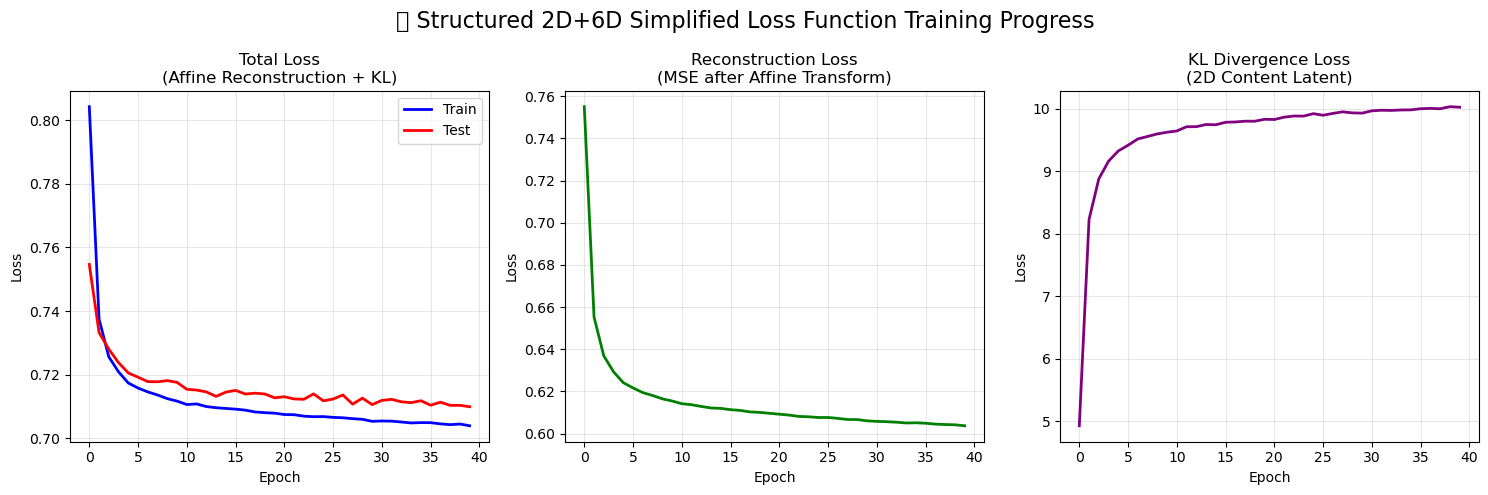


📊 Final Loss Values:
  Total Train Loss: 0.703916
  Total Test Loss: 0.709901
  Reconstruction Loss: 0.603710
  KL Divergence Loss: 10.020635


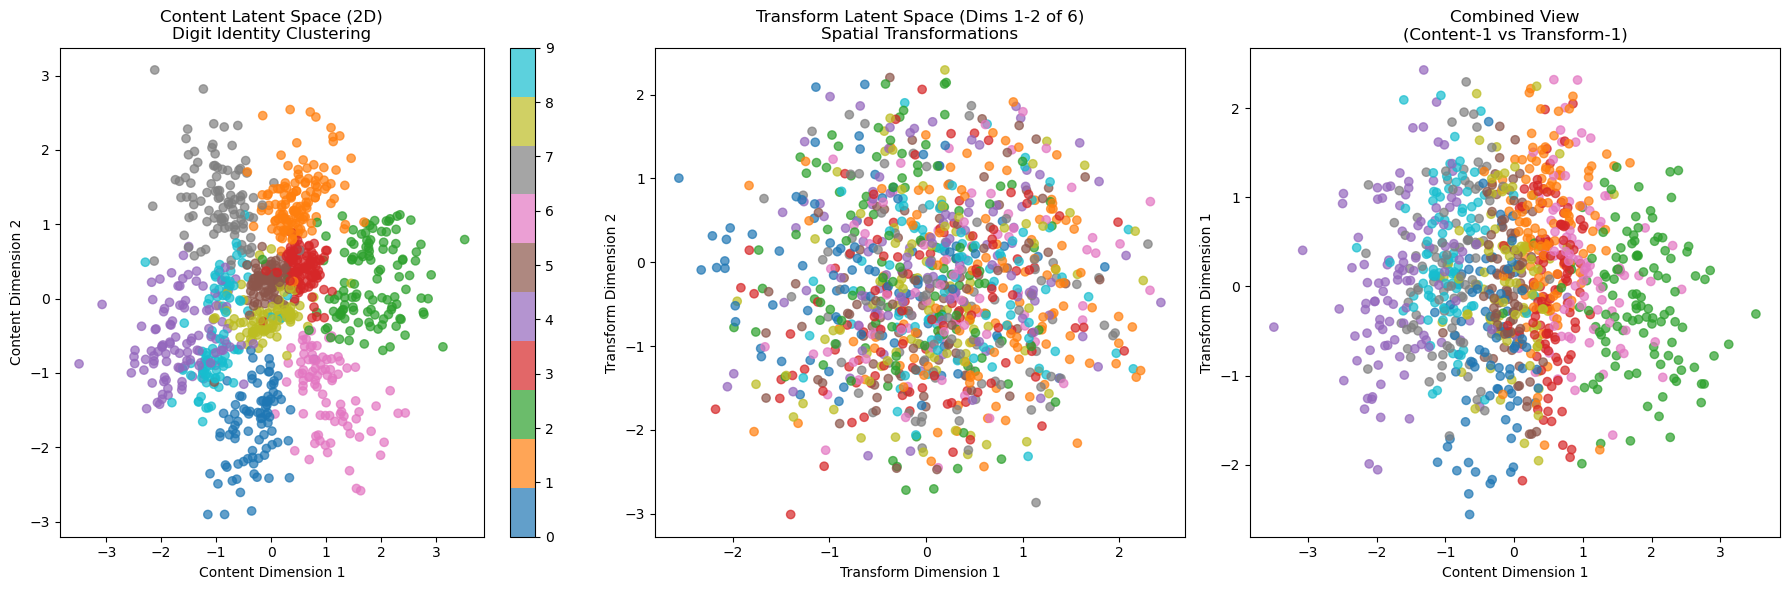

📊 Structured Latent Space Analysis:
  Content latent shape: (1000, 2)
  Transform latent shape: (1000, 6)
  Content variance: [1.162946  1.0599018]
  Transform variance: [0.7427749  0.9444075  0.8021894  0.25483435 0.15510152 0.26517338]


In [9]:
# 📈 VISUALIZE - Using explicit module references
s2d6d.plot_simplified_training_progress_structured(losses_dict)
content_data, transform_data, label_data = s2d6d.visualize_structured_latent_space(model, test_loader, device)

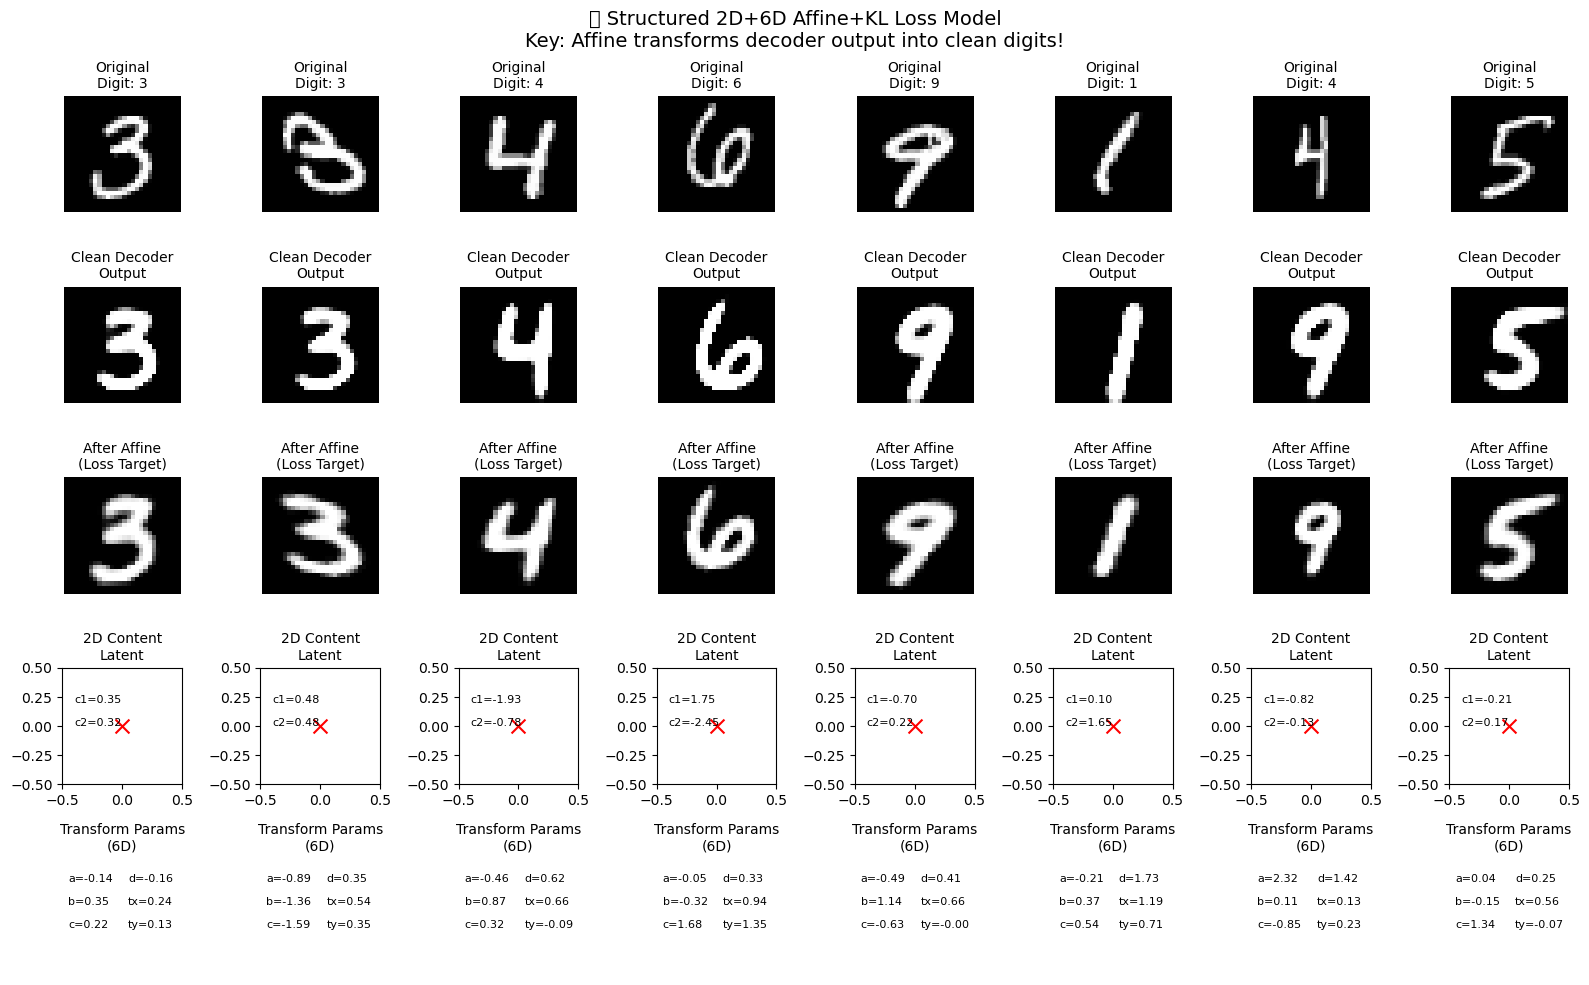


📊 Loss Analysis (Simplified Affine+KL Loss Function):
  Total Loss: 0.658689
  Reconstruction Loss (MSE after affine): 0.555065
  KL Divergence Loss (2D content latent): 10.362427
  Loss weights: α=1.0 (recon), β=0.01 (KL)

🎨 2D Content Latent Analysis:
  Content latent shape: torch.Size([8, 2])
  Content mu mean: [-0.11137992 -0.02957611]
  Content mu std: [1.1296085 1.1719164]
  Content logvar mean: [-3.5763497 -3.4510248]

🔧 6D Transform Latent Analysis:
  Transform latent shape: torch.Size([8, 6])
  Transform mu mean: [-0.02684786  0.10669202  0.18449801  0.50951445  0.7122642   0.33063692]
  Transform logvar mean: [-2.2481227 -1.7298739 -0.9829851 -2.6461568 -3.4412155 -3.369535 ]

🎯 UNIFIED 8D VAE:
  Full latent mu shape: torch.Size([8, 8])
  ALL 8 dimensions under KL regularization!
  This should provide much more stable training.


In [13]:
# 🎨 COMPREHENSIVE VISUALIZATIONS - Using structured_2d6d_autoencoder module
s2d6d.comprehensive_visualization_structured(model, test_loader, device, CONFIG)

In [7]:
# 💾 SAVE - Using shared save functionality from affine_autoencoder_shared
# Basic save (model, config, losses only - no extra visualization data)
model_file, metadata_file = shared.save_model_cloud(model, CONFIG, losses_dict, device)

💾 Saved: autoencoder_model_20250722_023100.pth, autoencoder_metadata_20250722_023100.json


In [8]:
# 💾 SAVE - UNIFIED 8D VAE MODEL
# This saves everything needed to recreate visualizations later
viz_filename = shared.save_model_for_viz(
    model, 
    model_type="unified_8d_vae",  # Updated to reflect unified architecture
    config=CONFIG,
    losses=losses_dict,
    extra_data={
        'content_data': content_data,
        'transform_data': transform_data,
        'label_data': label_data,
        'config': CONFIG,
        'architecture_version': 'unified_8d_v3'  # Version flag for compatibility
    },
    name="unified_8d_vae"  # Clear name for the unified architecture
)
print(f"💾 Model saved as: {viz_filename}")
print("🎯 This model uses the UNIFIED 8D VAE architecture with:")
print("  - Balanced KL regularization on all 8 dimensions")
print("  - Should show stable training and good digit clustering!")

💾 Saved unified_8d_vae model for visualization: unified_8d_vae_unified_8d_vae_20250722_023104.pth
💾 Model saved as: unified_8d_vae_unified_8d_vae_20250722_023104.pth
🎯 This model uses the UNIFIED 8D VAE architecture with:
  - Balanced KL regularization on all 8 dimensions
  - Should show stable training and good digit clustering!


In [11]:
#📁 LOAD MODEL FOR VISUALIZATION
#Run this cell to load a previously saved model instead of training from scratch
#NOTE: Fixed for PyTorch 2.6 weights_only issue

#Option 1: Load specific model by filename
model_path = 'structured_2d6d_simplified_20250721_013420.pth'
loaded_model, viz_data = shared.load_model_for_viz(model_path, 
                                                   s2d6d.StructuredAffineInvariantAutoEncoder, device)


📁 Loaded structured model from structured_2d6d_simplified_20250721_013420.pth
   Timestamp: 20250721_013420
   Device: cuda


In [18]:
viz_data.keys()

dict_keys(['config', 'losses', 'extra_data', 'timestamp', 'model_type', 'device'])

/home/exouser/Documents/adversAE/adversae/vae_training/affine/structured_2d6d_autoencoder.py:343: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/home/exouser/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


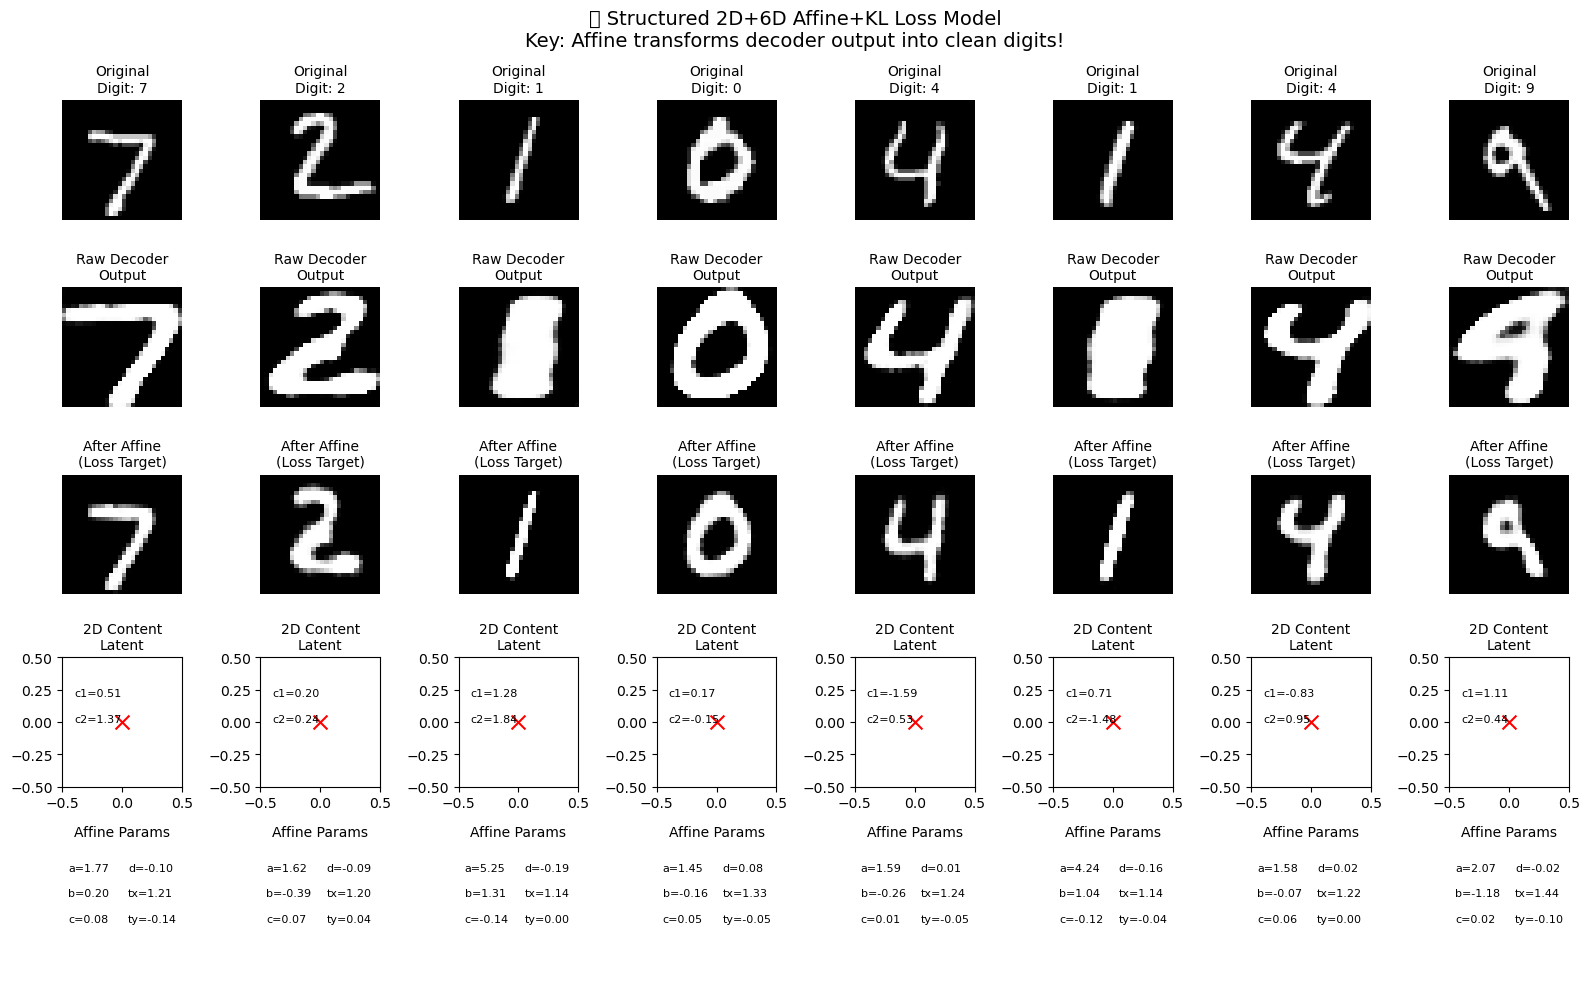


📊 Loss Analysis (Simplified Affine+KL Loss Function):
  Total Loss: 0.461004
  Reconstruction Loss (MSE after affine): 0.460158
  KL Divergence Loss (2D content latent): 0.846649
  Loss weights: α=1.0 (recon), β=0.001 (KL)

🎨 2D Content Latent Analysis:
  Content latent shape: torch.Size([8, 2])
  Content mu mean: [0.04174796 0.1323441 ]
  Content mu std: [0.674817   0.38179943]
  Content logvar mean: [-1.9465275 -0.2261337]

🔧 6D Transform Latent Analysis:
  Transform latent shape: torch.Size([8, 6])
  Transform mean: [-1.3637471  -1.4489424  -0.5418373  -2.2890437   2.6050673  -0.45559955]
  Transform std: [4.8383174 2.4993849 3.3657496 3.1386137 2.4901476 3.5223966]


In [12]:
s2d6d.comprehensive_visualization_structured(loaded_model, test_loader, device, CONFIG)

In [ ]:
# 📁 LOAD MODEL FOR VISUALIZATION
# Run this cell to load a previously saved model instead of training from scratch
# NOTE: Fixed for PyTorch 2.6 weights_only issue

# Option 1: Load specific model by filename
# model_path = '/path/to/your/structured_2d6d_simplified_20250720_123456.pth'
# loaded_model, viz_data = shared.load_model_for_viz(model_path, 
#                                                    s2d6d.StructuredAffineInvariantAutoEncoder, device)

# Option 2: Quick load most recent model
# loaded_model, viz_data = shared.quick_load_viz(s2d6d.StructuredAffineInvariantAutoEncoder, 
#                                                model_type="structured", name="2d6d_simplified", device=device)

# After loading, you can access:
# - loaded_model: The trained model ready for inference
# - viz_data['config']: Original training configuration  
# - viz_data['losses']: Training loss history
# - viz_data['extra_data']: Latent embeddings and other visualization data

# If you loaded a model, uncomment these lines to use it:
# model = loaded_model
# CONFIG = viz_data['config']
# losses_dict = viz_data['losses']
# if 'extra_data' in viz_data:
#     content_data = viz_data['extra_data'].get('content_data')
#     transform_data = viz_data['extra_data'].get('transform_data')
#     label_data = viz_data['extra_data'].get('label_data')

print("💡 Uncomment the lines above to load a saved model for visualization")